In [4]:
# Import section

from keras import Model,optimizers,layers
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from scikitplot.metrics import plot_confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
#Check if a GPU is available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
# Hyperparameters setting section
learning_rate = 1e-5
epochs = 100
batch_size = 8

In [ ]:
# Constants setting section
train_dir = '/content/drive/MyDrive/dataset/Train' # train directory path
valid_dir = '/content/drive/MyDrive/dataset/Validation' # validation directory path
test_dir = '/content/drive/MyDrive/dataset/Test'  # test directory path
img_height = 128
img_width  = 128

**Creación del dataset**

Para la creación del dataset de entrenamiento, validación y evaluación se utiliza el método *image_dataset_from_directory* que carga las imágenes y asigna las etiquetas atendiendo a la subestructura de las carpetas que se especifican en el parámetro *directory*.

En este caso, cada una de las respectivas carpetas está subdividida en dos carpetas: *fresh* y *rotten*, por lo que estas serán las etiquetas. Es posible definir el valor de batch_size e image_size. Por defecto, asigna el parámetro shuffle en True, lo que significa que los datos serán permutados antes de ser divididos en *batches*.

Los valores del canal RGB están en el rango [0, 255], por lo que debemos estandarizarlos para que estén en el rango [0, 1] usando tf.keras.layers.Rescaling.

In [ ]:
# Create train dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,image_size=(img_height, img_width),batch_size=batch_size)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 20569 files belonging to 2 classes.


In [ ]:
# Create validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,image_size=(img_height, img_width),batch_size=batch_size)
normalization_layer = tf.keras.layers.Rescaling(1./255)
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 2276 files belonging to 2 classes.


**Configurar el conjunto de datos para el entrenamiento**

Estos son dos métodos importantes que debes usar al cargar datos:
* *Dataset.cache*: mantiene las imágenes en la memoria después de que se cargan fuera del disco durante la primera época. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrenas tu modelo.

* *Dataset.prefetch*: superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.

En el problema en cuestión, el uso de estos métodos es realmente significativo, dado que el tamaño del conjunto de entrenamiento es bastante grande.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

**Instanciar el modelo VGG16**

Inicializamos el modelo con los pesos pre-entrenados en el dataset ImageNet, especificando *weights='imagenet'*. El parámetro *include_top* se refiere a si incluir o no las capas de clasificación del modelo, en este caso queremos sustituir estas capas por otras para realizar el fine-tuning, por lo que pasamos ese parámetro en False.

In [ ]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape = (img_height,img_width,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

**Agregar las capas de clasificación**

In [ ]:
def dropout_classifier(conv_base:Model):
    conv_base.trainable = False # freeze all convolutional base layers
    x = layers.Flatten()(conv_base.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=conv_base.input, outputs=predictions)

In [ ]:
model = dropout_classifier(conv_base)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

**Entrenamieno de las capas de clasificación**

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-5), metrics=['acc'])
history = model.fit(train_dataset, epochs = 10,validation_data=validation_dataset)
model.save('/content/drive/MyDrive/models/pre-train-dropout.h5')

Epoch 1/10
2572/2572 [==============================] - 15s 5ms/step - loss: 0.4866 - acc: 0.7610 - val_loss: 0.3536 - val_acc: 0.8554
Epoch 2/10
2572/2572 [==============================] - 14s 5ms/step - loss: 0.3423 - acc: 0.8481 - val_loss: 0.2948 - val_acc: 0.8796
Epoch 3/10
2572/2572 [==============================] - 14s 5ms/step - loss: 0.2926 - acc: 0.8725 - val_loss: 0.2647 - val_acc: 0.8880
Epoch 4/10
2572/2572 [==============================] - 14s 5ms/step - loss: 0.2660 - acc: 0.8885 - val_loss: 0.2442 - val_acc: 0.9003
Epoch 5/10
2572/2572 [==============================] - 14s 5ms/step - loss: 0.2439 - acc: 0.8982 - val_loss: 0.2347 - val_acc: 0.9038
Epoch 6/10
2572/2572 [==============================] - 14s 5ms/step - loss: 0.2315 - acc: 0.9047 - val_loss: 0.2239 - val_acc: 0.9082
Epoch 7/10
2572/2572 [==============================] - 14s 5ms/step - loss: 0.2180 - acc: 0.9117 - val_loss: 0.2165 - val_acc: 0.9117
Epoch 8/10
2572/2572 [==============================] -

**Descongelar las capas correspondientes al último bloque de convolución.**

In [ ]:
def unfreeze_layers(model:Model, umbral_layer:str):
    ''' Freeze all layers up to layer specified in umbral_layer'''
    model.trainable = True
    set_trainable = False

    for layer in model.layers:
            if layer.name == umbral_layer:
              set_trainable = True
            layer.trainable = set_trainable

In [ ]:
unfreeze_layers(model,'block5_conv1')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

**Entrenar el modelo nuevamente**

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=learning_rate), metrics=['acc'])
history = model.fit(train_dataset, epochs = 50, validation_data = validation_dataset)
model.save('/content/drive/MyDrive/models/dropout.h5')

Epoch 1/50
2572/2572 [==============================] - 16s 6ms/step - loss: 0.1444 - acc: 0.9454 - val_loss: 0.0895 - val_acc: 0.9679
Epoch 2/50
2572/2572 [==============================] - 15s 6ms/step - loss: 0.0677 - acc: 0.9768 - val_loss: 0.0683 - val_acc: 0.9745
Epoch 3/50
2572/2572 [==============================] - 15s 6ms/step - loss: 0.0450 - acc: 0.9849 - val_loss: 0.0864 - val_acc: 0.9706
Epoch 4/50
2572/2572 [==============================] - 15s 6ms/step - loss: 0.0373 - acc: 0.9898 - val_loss: 0.0734 - val_acc: 0.9785
Epoch 5/50
2572/2572 [==============================] - 15s 6ms/step - loss: 0.0320 - acc: 0.9920 - val_loss: 0.0936 - val_acc: 0.9772
Epoch 6/50
2572/2572 [==============================] - 15s 6ms/step - loss: 0.0274 - acc: 0.9930 - val_loss: 0.0943 - val_acc: 0.9807
Epoch 7/50
2572/2572 [==============================] - 15s 6ms/step - loss: 0.0246 - acc: 0.9943 - val_loss: 0.0720 - val_acc: 0.9846
Epoch 8/50
2572/2572 [==============================] -

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


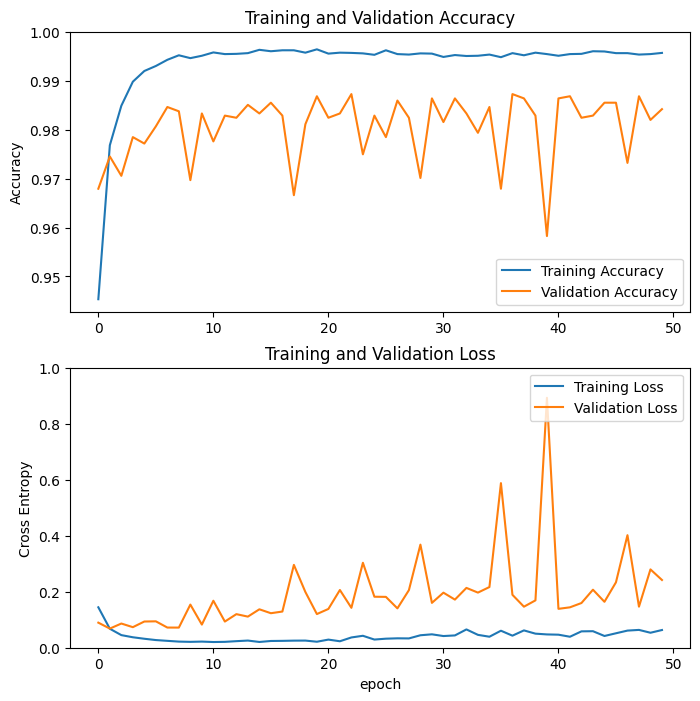

In [ ]:
plot_learning_curve(history)

**Cargar dataset de evaluación**

In [11]:
# Create test datasets
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(img_height, img_width),batch_size=batch_size,shuffle = False)
class_names = test_dataset.class_names # represents the class names obteined from the directory 
print(class_names) 
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 7512 files belonging to 2 classes.
['fresh', 'rotten']


In [12]:

test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

**Obtener las predicciones del modelo**

In [14]:

predictions = model.predict(test_dataset)

939/939 [==============================] - 863s 909ms/step


En este paso se determina, dada la probabilidad que devuelve la evaluación del modelo, cuál es la etiqueta que predice. Si la probabilidad es mayor que 0.5, la evaluación es 1, lo que significa que la etiqueta predicha es *rotten*, puesto que esta en la posición 1 de la lista de *class_names* del dataset. 

In [26]:

predicted_labels = [ 'rotten' if pred.astype("int32") > 0.5 else 'fresh'  for pred in predictions ]

fresh_samples = 3642 
rotten_samples = 7512 - fresh_samples

# true labels for test samples
true_labels = ['fresh']*fresh_samples + ['rotten']*rotten_samples 

**Cálculo de las métricas de evaluación**

In [27]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy : {accuracy}")

Accuracy : 0.9542066027689031


In [28]:
# precision tp / (tp + fp)
fresh_precision = precision_score(true_labels, predicted_labels,pos_label='fresh')
rotten_precision = precision_score(true_labels, predicted_labels,pos_label='rotten')
print("Precision")
print(f"fresh: {fresh_precision}" )
print(f"rotten: {rotten_precision}")

Precision
fresh: 0.9174683544303798
rotten: 0.9949466591802358


In [29]:
# recall: tp / (tp + fn)
fresh_recall = recall_score(true_labels, predicted_labels, pos_label='fresh')
rotten_recall = recall_score(true_labels, predicted_labels, pos_label='rotten')
print("Recall")
print(f"fresh: {fresh_recall}" )
print(f"rotten: {rotten_recall}")

Recall
fresh: 0.9950576606260296
rotten: 0.9157622739018088


In [30]:
# f1: 2 tp / (2 tp + fp + fn)
fresh_f1 = f1_score(true_labels, predicted_labels, pos_label='fresh')
rotten_f1 = f1_score(true_labels, predicted_labels, pos_label='rotten')
print("F1 score")
print(f"fresh: {fresh_f1}" )
print(f"rotten {rotten_f1}")

F1 score
fresh: 0.9546891464699684
rotten 0.953713670613563


In [31]:
auc = roc_auc_score(true_labels, predictions)
print(f"AUC-ROC Curve: {auc}" )

AUC-ROC Curve: 0.9969789010496264


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

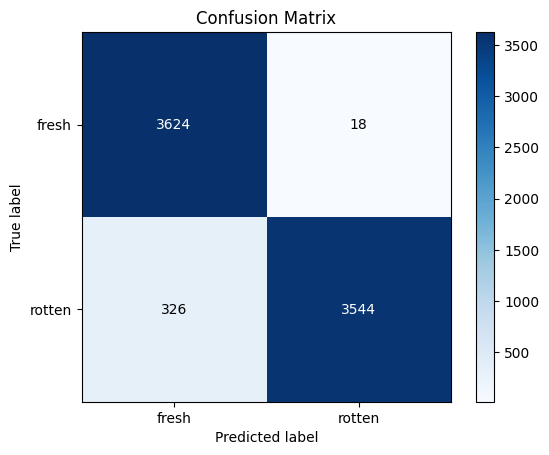

In [25]:
plot_confusion_matrix(true_labels,predicted_labels)